Import necessary libraries

In [2]:
import numpy as np
from scipy.stats import weibull_min, expon, norm
import scipy.stats as stats
import matplotlib.pyplot as plt

### Challenge 1: Non-repairable Components

1- Variable Speed Drive (V)

Visualize the data

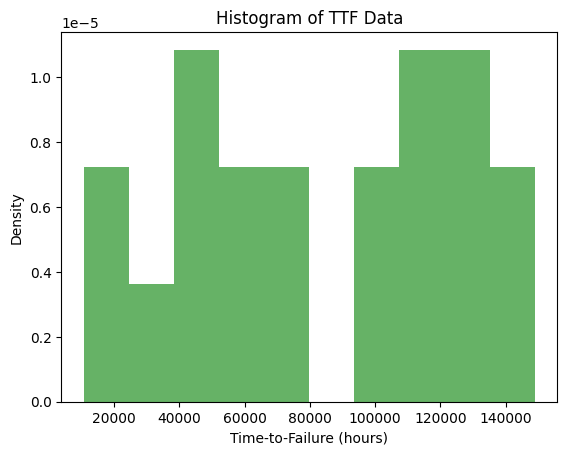

In [3]:
# TTF data for Variable Speed Drive (V) in hours
ttf_v_data = np.array([
    1.0650, 0.4772, 0.5071, 1.3398, 1.4893, 0.7071, 0.1072, 0.9460, 0.5936, 1.1777,
    0.2627, 1.3126, 1.4565, 0.6882, 1.3217, 0.4129, 0.1682, 1.1197, 0.6564, 1.1737
]) * 1e5  # Convert to hours

# Visualisation data by histogram
plt.hist(ttf_v_data, bins=10, density=True, alpha=0.6, color='g')
plt.title('Histogram of TTF Data')
plt.xlabel('Time-to-Failure (hours)')
plt.ylabel('Density')
plt.show()

Fit different distributions to the data

In [4]:
# Exponential distribution
exp_params = stats.expon.fit(ttf_v_data)
# Weibull distribution
weib_params = stats.weibull_min.fit(ttf_v_data)
# Log-Normal distribution
lognorm_params = stats.lognorm.fit(ttf_v_data)


Choose the most well-fitted distribution

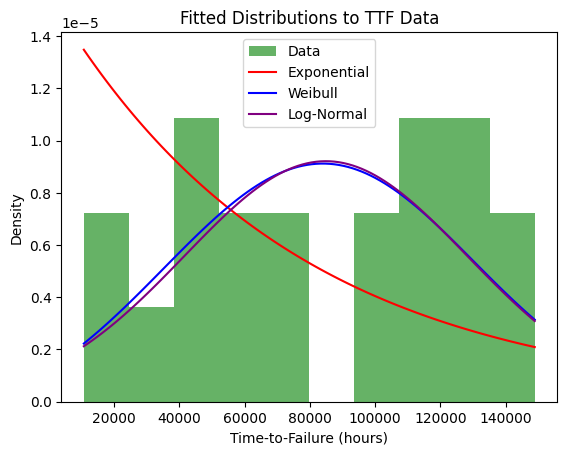

In [5]:
# Generate values for the X-axis to plot the fitted distributions
x = np.linspace(min(ttf_v_data), max(ttf_v_data), 100)

# Plot the histogram and the fitted distributions
plt.hist(ttf_v_data, bins=10, density=True, alpha=0.6, color='g', label='Data')

# Plot Exponential distribution
pdf_exp = stats.expon.pdf(x, *exp_params)
plt.plot(x, pdf_exp, label="Exponential", color='red')

# Plot Weibull distribution
pdf_weib = stats.weibull_min.pdf(x, *weib_params)
plt.plot(x, pdf_weib, label="Weibull", color='blue')

# Plot Log-Normal distribution
pdf_lognorm = stats.lognorm.pdf(x, *lognorm_params)
plt.plot(x, pdf_lognorm, label="Log-Normal", color='purple')

# Display the plot
plt.title('Fitted Distributions to TTF Data')
plt.xlabel('Time-to-Failure (hours)')
plt.ylabel('Density')
plt.legend()
plt.show()

Calculate the p-value for each distribution

In [6]:
ks_exp_pvalue = stats.kstest(ttf_v_data, 'expon', args=exp_params).pvalue
ks_weib_pvalue = stats.kstest(ttf_v_data, 'weibull_min', args=weib_params).pvalue
ks_lognorm_pvalue = stats.kstest(ttf_v_data, 'lognorm', args=lognorm_params).pvalue

# Print the p-values in a formatted manner
print(f"p-value for Exponential Distribution: {ks_exp_pvalue:.4f}")
print(f"p-value for Weibull Distribution: {ks_weib_pvalue:.4f}")
print(f"p-value for Log-Normal Distribution: {ks_lognorm_pvalue:.4f}")

p-value for Exponential Distribution: 0.3971
p-value for Weibull Distribution: 0.7699
p-value for Log-Normal Distribution: 0.7716


We chose the Weibull distribution

In [7]:
# Fit Weibull distribution to TTF data for V
params_v = weibull_min.fit(ttf_v_data, floc=0)
shape_v, loc_v, scale_v = params_v

2- Compressor (C) and Gearbox (G)

In [8]:
# Failure rates for Compressor (C) and Gearbox (G)
# Compressor failure rate (per hour)
lambda_c = 524.46e-6 / (365 * 24)  # Convert per year to per hour

# Gearbox failure rate (assumed, per hour)
# Assuming a failure rate of 0.455 per year for Gearbox
lambda_g = 0.455 / (365 * 24)  # Convert per year to per hour


3- Motor (M)

In [9]:
# Function to generate TTF for Motor (M)
def generate_ttf_m():
    while True:
        a = np.random.normal(1e-7, 0.2e-7)
        b = np.random.normal(1.5, 0.1)
        if a > 0 and b > 0:
            break
    ttf_m = (1.25 / a) ** (1 / b)
    return ttf_m

Simulate the life test 10000 times

In [10]:
# Simulation parameters
num_simulations = 10000
success_count = 0

for _ in range(num_simulations):
    cds_failure_times = []
    for _ in range(6):  # Six CDS units
        # Generate TTF for each component
        ttf_v = weibull_min.rvs(shape_v, loc=0, scale=scale_v)
        ttf_m = generate_ttf_m()
        ttf_c = expon.rvs(scale=1 / lambda_c)
        ttf_g = expon.rvs(scale=1 / lambda_g)
        # Time to failure for CDS (minimum of its components)
        ttf_cds = min(ttf_v, ttf_m, ttf_c, ttf_g)
        cds_failure_times.append(ttf_cds)
    # Check system availability
    cds_failure_times = np.sort(cds_failure_times)
    # Winter period: first 4380 hours (6 months)
    if np.min(cds_failure_times) < 4380:
        continue  # System fails during winter
    # Summer period: next 4380 hours
    operational_cds = 6
    system_fail = False
    for failure_time in cds_failure_times:
        if 4380 <= failure_time <= 8760:
            operational_cds -= 1
            if operational_cds < 3:
                system_fail = True
                break
    if system_fail:
        continue  # System fails during summer
    success_count += 1  # System meets demand for the entire year

Calculate the probability of meeting demand

In [11]:
probability = success_count / num_simulations
print(f"Probability of meeting demand: {probability:.4f}")

if probability >= 0.95:
    print("The current system design satisfies the manager's requirement.")
else:
    print("The current system design does NOT satisfy the manager's requirement.")
    print("Consider implementing improvement measures.")

Probability of meeting demand: 0.2488
The current system design does NOT satisfy the manager's requirement.
Consider implementing improvement measures.


### Challenge 2: Repairable Components

Repair times

In [ ]:
# Repair times (in hours)
repair_time_vgc = 7 * 24  # 1 week in hours
repair_time_m = 2 * 30 * 24  # 2 months in hours

# Mean repair rates (per hour)
mu_vgc = 1 / repair_time_vgc
mu_m = 1 / repair_time_m

Simulate the life test 10000 times

In [ ]:
# Simulation parameters for repairable system
num_simulations = 10000
success_count_repairable = 0

for _ in range(num_simulations):
    # Initialize system status
    cds_status = np.ones(6)  # 1 means operational, 0 means failed
    component_status = {
        'V': np.ones(6),
        'M': np.ones(6),
        'G': np.ones(6),
        'C': np.ones(6)
    }
    event_list = []
    # Schedule initial failures for each component in each CDS
    for i in range(6):
        # Schedule TTF for each component
        ttf_v = weibull_min.rvs(shape_v, loc=0, scale=scale_v)
        ttf_m = generate_ttf_m()
        ttf_c = expon.rvs(scale=1 / lambda_c)
        ttf_g = expon.rvs(scale=1 / lambda_g)
        # Schedule events (failure times)
        event_list.extend([
            (ttf_v, 'V', i),
            (ttf_m, 'M', i),
            (ttf_c, 'C', i),
            (ttf_g, 'G', i)
        ])
    # Event simulation
    event_list.sort()
    operational_cds = 6
    time = 0
    system_fail = False
    while time <= 8760:
        if not event_list:
            break
        event = event_list.pop(0)
        time, component, i = event
        if component.endswith('_repair'):
            # Repair event
            comp = component.replace('_repair', '')
            component_status[comp][i] = 1  # Component repaired
            # Schedule next failure
            if comp == 'V':
                ttf_next = time + weibull_min.rvs(shape_v, loc=0, scale=scale_v)
            elif comp == 'M':
                ttf_next = time + generate_ttf_m()
            elif comp == 'C':
                ttf_next = time + expon.rvs(scale=1 / lambda_c)
            elif comp == 'G':
                ttf_next = time + expon.rvs(scale=1 / lambda_g)
            event_list.append((ttf_next, comp, i))
            event_list.sort()
            # Check if CDS is back up
            if cds_status[i] == 0 and all(component_status[comp][i] == 1 for comp in ['V', 'M', 'G', 'C']):
                cds_status[i] = 1
                operational_cds += 1
        else:
            # Failure event
            if component_status[component][i] == 1:
                component_status[component][i] = 0  # Component fails
                # Schedule repair
                if component in ['V', 'G', 'C']:
                    repair_time = expon.rvs(scale=1 / mu_vgc)
                else:  # Motor M
                    repair_time = expon.rvs(scale=1 / mu_m)
                # Schedule the component to be repaired
                event_list.append((time + repair_time, component + '_repair', i))
                event_list.sort()
                # Check if CDS is down
                if cds_status[i] == 1 and any(component_status[comp][i] == 0 for comp in ['V', 'M', 'G', 'C']):
                    cds_status[i] = 0
                    operational_cds -= 1
        # Check system status
        if time <= 4380 and operational_cds < 6:
            system_fail = True
            break
        elif 4380 < time <= 8760 and operational_cds < 3:
            system_fail = True
            break
    if not system_fail:
        success_count_repairable += 1

Calculate the probability of meeting demand with repairable components

In [ ]:
probability_repairable = success_count_repairable / num_simulations
print(f"\nProbability of meeting demand with repairable components: {probability_repairable:.4f}")

if probability_repairable >= 0.95:
    print("The current design with repairable components satisfies the manager's requirement.")
else:
    print("The current design with repairable components does NOT satisfy the manager's requirement.")
    print("Consider reducing repair times or increasing redundancy.")